##SigNet: Convolutional Siamese Network for Writer Independent Offline Signature Verification

In [1]:
cd /content

/content


In [2]:
import kagglehub
path = kagglehub.dataset_download("ishanikathuria/handwritten-signature-datasets")

print("Path to dataset files:", path)

100%|██████████| 290M/290M [00:06<00:00, 45.2MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/ishanikathuria/handwritten-signature-datasets/versions/3


In [3]:
!kaggle datasets download ishanikathuria/handwritten-signature-datasets

Dataset URL: https://www.kaggle.com/datasets/ishanikathuria/handwritten-signature-datasets
License(s): other
 98% 286M/290M [00:04<00:00, 42.3MB/s]
100% 290M/290M [00:04<00:00, 65.7MB/s]


In [4]:
!mkdir -p /content/data
%cd /content/data

/content/data


In [5]:
!unzip /content/handwritten-signature-datasets.zip

Streaming output truncated to the last 5000 lines.
  inflating: BHSig260-Hindi/BHSig260-Hindi/6/H-S-6-F-17.tif  
  inflating: BHSig260-Hindi/BHSig260-Hindi/6/H-S-6-F-18.tif  
  inflating: BHSig260-Hindi/BHSig260-Hindi/6/H-S-6-F-19.tif  
  inflating: BHSig260-Hindi/BHSig260-Hindi/6/H-S-6-F-20.tif  
  inflating: BHSig260-Hindi/BHSig260-Hindi/6/H-S-6-F-21.tif  
  inflating: BHSig260-Hindi/BHSig260-Hindi/6/H-S-6-F-22.tif  
  inflating: BHSig260-Hindi/BHSig260-Hindi/6/H-S-6-F-23.tif  
  inflating: BHSig260-Hindi/BHSig260-Hindi/6/H-S-6-F-24.tif  
  inflating: BHSig260-Hindi/BHSig260-Hindi/6/H-S-6-F-25.tif  
  inflating: BHSig260-Hindi/BHSig260-Hindi/6/H-S-6-F-26.tif  
  inflating: BHSig260-Hindi/BHSig260-Hindi/6/H-S-6-F-27.tif  
  inflating: BHSig260-Hindi/BHSig260-Hindi/6/H-S-6-F-28.tif  
  inflating: BHSig260-Hindi/BHSig260-Hindi/6/H-S-6-F-29.tif  
  inflating: BHSig260-Hindi/BHSig260-Hindi/6/H-S-6-F-30.tif  
  inflating: BHSig260-Hindi/BHSig260-Hindi/6/H-S-6-G-01.tif  
  inflating: BHSig2

In [6]:
import sys
import numpy as np
import pickle
import os
import matplotlib.pyplot as plt
%matplotlib inline

import cv2
import time
import itertools
import random

from sklearn.utils import shuffle

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate, Dropout
from tensorflow.keras.models import Model

from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.layers import Lambda, Flatten, Dense
from tensorflow.keras.initializers import glorot_uniform

from tensorflow.keras.layers import Layer
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [7]:
# Enable memory growth
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

In [24]:
# Dataset path
path = "./BHSig260-Bengali/BHSig260-Bengali/"
#path = "./CEDAR/CEDAR/"

# Data Prep for CEDAR

In [9]:
# Get the list of all directories and sort them
dir_list = next(os.walk(path))[1]
dir_list.sort()

In [10]:
#Train CEDAR dataset use this cell

# For each person segregate the genuine signatures from the forged signatures
# Genuine signatures are stored in the list "orig_groups"
# Forged signatures are stored in the list "forged_groups"
orig_groups, forg_groups = [], []
for directory in dir_list:
    images = os.listdir(path+directory)
    images.sort()
    images = [path+directory+'/'+x for x in images]
    forg_groups.append(images[:24]) # First 24 signatures in each folder are forrged
    orig_groups.append(images[24:]) # Next 24 signatures are genuine

In [11]:
# Quick check to confirm we have data of all the individuals
len(orig_groups), len(forg_groups)

(55, 55)

In [12]:
orig_lengths = [len(x) for x in orig_groups]
forg_lengths = [len(x) for x in forg_groups]

In [13]:
# Quick check to confirm that there are 24 Genuine signatures for each individual
print(orig_lengths)

[24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24]


In [14]:
# Quick check to confirm that there are 30 Forged signatures for each individual
print(forg_lengths)

[24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24]


In [15]:
#Train CEDAR dataset use this cell
orig_train, orig_val, orig_test = orig_groups[:45], orig_groups[45:50], orig_groups[50:]
forg_train, forg_val, forg_test = forg_groups[:45], forg_groups[45:50], forg_groups[50:]

In [16]:
# Delete unnecessary variables
del orig_groups, forg_groups

In [17]:
# All the images will be converted to the same size before processing
img_h, img_w = 155, 220

In [18]:
def visualize_sample_signature():
    '''Function to randomly select a signature from train set and
    print two genuine copies and one forged copy'''
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (10, 10))
    k = np.random.randint(len(orig_train))
    orig_img_names = random.sample(orig_train[k], 2)
    forg_img_name = random.sample(forg_train[k], 1)
    orig_img1 = cv2.imread(orig_img_names[0], 0)
    orig_img2 = cv2.imread(orig_img_names[1], 0)
    forg_img = plt.imread(forg_img_name[0], 0)
    orig_img1 = cv2.resize(orig_img1, (img_w, img_h))
    orig_img2 = cv2.resize(orig_img2, (img_w, img_h))
    forg_img = cv2.resize(forg_img, (img_w, img_h))

    ax1.imshow(orig_img1, cmap = 'gray')
    ax2.imshow(orig_img2, cmap = 'gray')
    ax3.imshow(forg_img, cmap = 'gray')

    ax1.set_title('Genuine Copy')
    ax1.axis('off')
    ax2.set_title('Genuine Copy')
    ax2.axis('off')
    ax3.set_title('Forged Copy')
    ax3.axis('off')

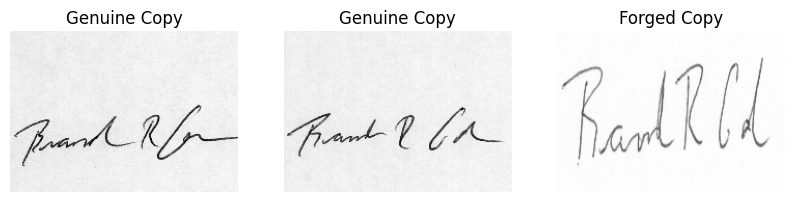

In [19]:
visualize_sample_signature()

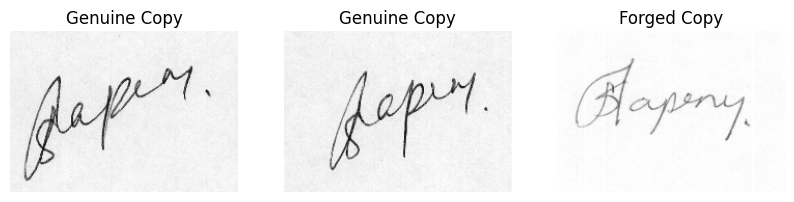

In [20]:
visualize_sample_signature()

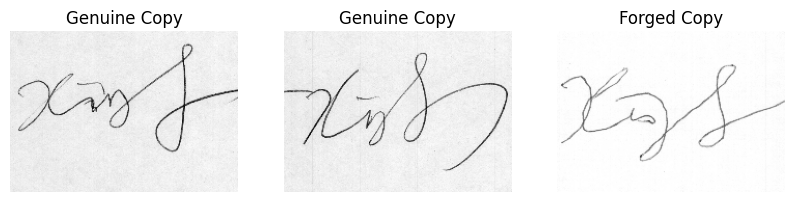

In [21]:
visualize_sample_signature()

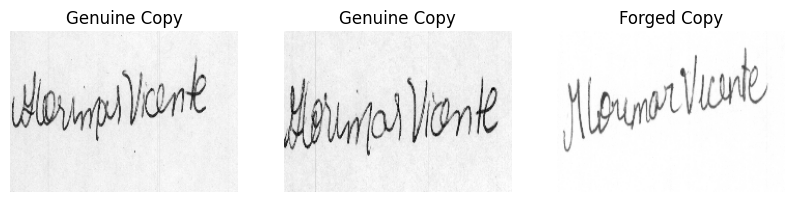

In [22]:
visualize_sample_signature()

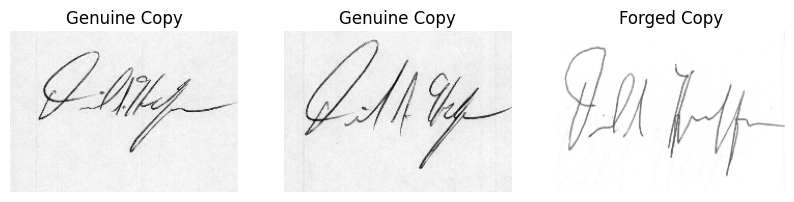

In [23]:
visualize_sample_signature()

# Data Prep for BHSig260-Bengali

In [25]:
# Get the list of all directories and sort them
dir_list = next(os.walk(path))[1]
dir_list.sort()

In [26]:
#Train BHSig260 dataset use this cell

# For each person segregate the genuine signatures from the forged signatures
# Genuine signatures are stored in the list "orig_groups"
# Forged signatures are stored in the list "forged_groups"
orig_groups, forg_groups = [], []
for directory in dir_list:
    images = os.listdir(path+directory)
    images.sort()
    images = [path+directory+'/'+x for x in images]
    forg_groups.append(images[:30]) # First 30 signatures in each folder are forrged
    orig_groups.append(images[30:]) # Next 24 signatures are genuine

In [27]:
# Quick check to confirm we have data of all the individuals
len(orig_groups), len(forg_groups)

(100, 100)

In [28]:
orig_lengths = [len(x) for x in orig_groups]
forg_lengths = [len(x) for x in forg_groups]

In [29]:
# Quick check to confirm that there are 24 Genuine signatures for each individual
print(orig_lengths)

[24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24]


In [30]:
# Quick check to confirm that there are 30 Forged signatures for each individual
print(forg_lengths)

[30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30]


In [31]:
#Train BHSig260-Bengali dataset use this cell
orig_train, orig_val, orig_test = orig_groups[:80], orig_groups[80:90], orig_groups[90:]
forg_train, forg_val, forg_test = forg_groups[:80], forg_groups[80:90], forg_groups[90:]

In [32]:
# Delete unnecessary variables
del orig_groups, forg_groups

In [33]:
# All the images will be converted to the same size before processing
img_h, img_w = 155, 220

In [34]:
def visualize_sample_signature():
    '''Function to randomly select a signature from train set and
    print two genuine copies and one forged copy'''
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (10, 10))
    k = np.random.randint(len(orig_train))
    orig_img_names = random.sample(orig_train[k], 2)
    forg_img_name = random.sample(forg_train[k], 1)
    orig_img1 = cv2.imread(orig_img_names[0], 0)
    orig_img2 = cv2.imread(orig_img_names[1], 0)
    forg_img = plt.imread(forg_img_name[0], 0)
    orig_img1 = cv2.resize(orig_img1, (img_w, img_h))
    orig_img2 = cv2.resize(orig_img2, (img_w, img_h))
    forg_img = cv2.resize(forg_img, (img_w, img_h))

    ax1.imshow(orig_img1, cmap = 'gray')
    ax2.imshow(orig_img2, cmap = 'gray')
    ax3.imshow(forg_img, cmap = 'gray')

    ax1.set_title('Genuine Copy')
    ax1.axis('off')
    ax2.set_title('Genuine Copy')
    ax2.axis('off')
    ax3.set_title('Forged Copy')
    ax3.axis('off')

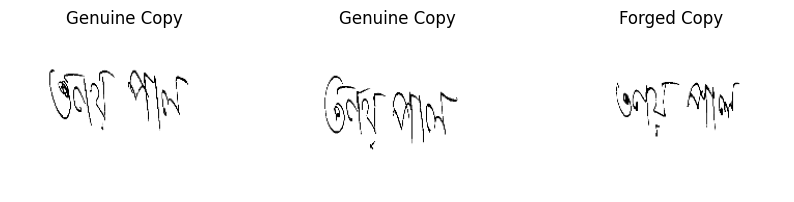

In [35]:
visualize_sample_signature()

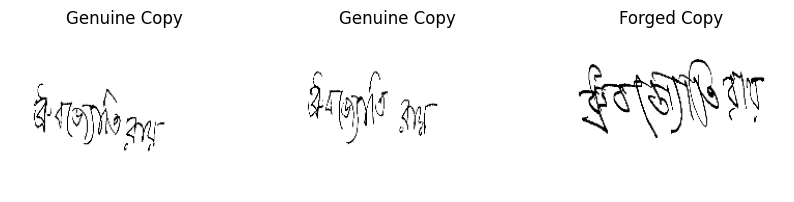

In [36]:
visualize_sample_signature()

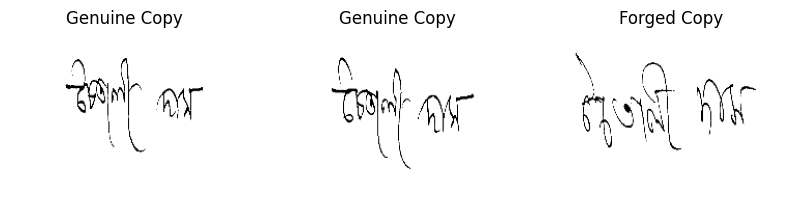

In [37]:
visualize_sample_signature()

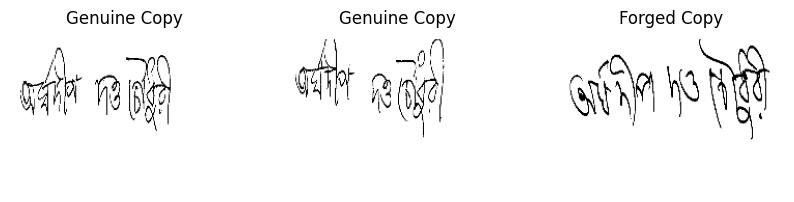

In [38]:
visualize_sample_signature()

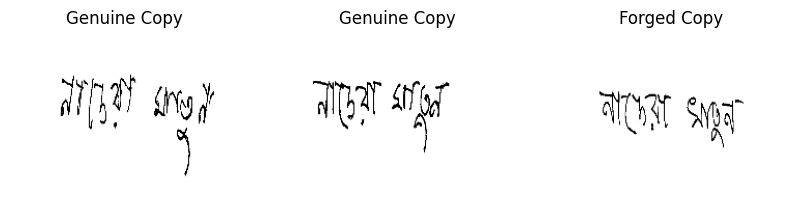

In [39]:
visualize_sample_signature()

# Data Pre-processing

In [ ]:
def generate_batch(orig_groups, forg_groups, batch_size=32):
    '''Function to generate a batch of data with batch_size number of data points
    Half of the data points will be Genuine-Genuine pairs and half will be Genuine-Forged pairs'''
    img_h, img_w = 155, 220  # Assuming image height and width are 155 and 220, respectively
    while True:
        orig_pairs = []
        forg_pairs = []
        gen_gen_labels = []
        gen_for_labels = []
        all_pairs = []
        all_labels = []

        for orig, forg in zip(orig_groups, forg_groups):
            orig_pairs.extend(list(itertools.combinations(orig, 2)))
            forg_list = list(forg)  # Ensure forg is a list
            for i in range(len(forg_list)):
                forg_pairs.extend(list(itertools.product(orig[i:i + 1], random.sample(forg_list, 12))))

        # Label for Genuine-Genuine pairs is 1
        # Label for Genuine-Forged pairs is 0
        gen_gen_labels = [1] * len(orig_pairs)
        gen_for_labels = [0] * len(forg_pairs)

        # Concatenate all the pairs together along with their labels and shuffle them
        all_pairs = orig_pairs + forg_pairs
        all_labels = gen_gen_labels + gen_for_labels
        del orig_pairs, forg_pairs, gen_gen_labels, gen_for_labels
        all_pairs, all_labels = shuffle(all_pairs, all_labels)

        k = 0
        pairs = [np.zeros((batch_size, img_h, img_w, 1), dtype=np.float32) for _ in range(2)]
        targets = np.zeros((batch_size,), dtype=np.float32)

        for ix, pair in enumerate(all_pairs):
            # Ensure pair elements are strings
            path1 = pair[0].decode('utf-8') if isinstance(pair[0], bytes) else pair[0]
            path2 = pair[1].decode('utf-8') if isinstance(pair[1], bytes) else pair[1]

            img1 = cv2.imread(path1, 0)
            img2 = cv2.imread(path2, 0)
            img1 = cv2.resize(img1, (img_w, img_h))          #Resizing Images
            img2 = cv2.resize(img2, (img_w, img_h))
            img1 = np.array(img1, dtype=np.float64)
            img2 = np.array(img2, dtype=np.float64)
            img1 /= 255                                     #Normalizing Images
            img2 /= 255
            img1 = img1[..., np.newaxis]
            img2 = img2[..., np.newaxis]
            pairs[0][k, :, :, :] = img1
            pairs[1][k, :, :, :] = img2
            targets[k] = all_labels[ix]
            k += 1
            if k == batch_size:
                yield (tf.convert_to_tensor(pairs[0], dtype=tf.float32), tf.convert_to_tensor(pairs[1], dtype=tf.float32)), tf.convert_to_tensor(targets, dtype=tf.float32)
                k = 0
                pairs = [np.zeros((batch_size, img_h, img_w, 1), dtype=np.float32) for _ in range(2)]
                targets = np.zeros((batch_size,), dtype=np.float32)

In [ ]:
#Creating a tf Dataset from generator
def ensure_list(groups):
    return [list(group) if not isinstance(group, list) else group for group in groups]

orig_train = ensure_list(orig_train)
forg_train = ensure_list(forg_train)
orig_val = ensure_list(orig_val)
forg_val = ensure_list(forg_val)

def create_dataset(generator_func, orig_groups, forg_groups, batch_size, img_h, img_w):
    output_signature = (
        (
            tf.TensorSpec(shape=(batch_size, img_h, img_w, 1), dtype=tf.float32),
            tf.TensorSpec(shape=(batch_size, img_h, img_w, 1), dtype=tf.float32)
        ),
        tf.TensorSpec(shape=(batch_size,), dtype=tf.float32)
    )

    dataset = tf.data.Dataset.from_generator(
        generator_func,
        args=[orig_groups, forg_groups, batch_size],
        output_signature=output_signature
    )
    return dataset

# Model Training

In [ ]:
def euclidean_distance(vects):
    '''Compute Euclidean Distance between two vectors'''
    x, y = vects
    return K.sqrt(K.sum(K.square(x - y), axis=1, keepdims=True))

In [ ]:
def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

In [ ]:
def contrastive_loss(y_true, y_pred):
    '''Contrastive loss from Hadsell-et-al.'06
    http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    '''
    margin = 1
    return K.mean(y_true * K.square(y_pred) + (1 - y_true) * K.square(K.maximum(margin - y_pred, 0)))

![Model Architecture](https://github.com/GAURAV2567/Kaggle_CMI/blob/main/Model%20Architecture.JPG?raw=true)

##### Additional Details can be found in the Paper

In [ ]:
def create_base_network_signet(input_shape):
    '''Base Siamese Network'''
    seq = Sequential()
    seq.add(Input(shape=input_shape))  # Define input shape using an Input layer

    seq.add(Conv2D(96, kernel_size=(11, 11), activation='relu', name='conv1_1', strides=4, kernel_initializer='glorot_uniform', data_format='channels_last'))
    seq.add(BatchNormalization(epsilon=1e-06, axis=-1, momentum=0.9))
    seq.add(MaxPooling2D((3, 3), strides=(2, 2)))
    seq.add(ZeroPadding2D((2, 2), data_format='channels_last'))

    seq.add(Conv2D(256, kernel_size=(5, 5), activation='relu', name='conv2_1', strides=1, kernel_initializer='glorot_uniform', data_format='channels_last'))
    seq.add(BatchNormalization(epsilon=1e-06, axis=-1, momentum=0.9))
    seq.add(MaxPooling2D((3, 3), strides=(2, 2)))
    seq.add(Dropout(0.3))  # added extra
    seq.add(ZeroPadding2D((1, 1), data_format='channels_last'))

    seq.add(Conv2D(384, kernel_size=(3, 3), activation='relu', name='conv3_1', strides=1, kernel_initializer='glorot_uniform', data_format='channels_last'))
    seq.add(ZeroPadding2D((1, 1), data_format='channels_last'))

    seq.add(Conv2D(256, kernel_size=(3, 3), activation='relu', name='conv3_2', strides=1, kernel_initializer='glorot_uniform', data_format='channels_last'))
    seq.add(MaxPooling2D((3, 3), strides=(2, 2)))
    seq.add(Dropout(0.3))  # added extra
    seq.add(Flatten(name='flatten'))
    seq.add(Dense(1024, kernel_regularizer=l2(0.0005), activation='relu', kernel_initializer='glorot_uniform'))
    seq.add(Dropout(0.5))

    seq.add(Dense(128, kernel_regularizer=l2(0.0005), activation='relu', kernel_initializer='glorot_uniform'))  # softmax changed to relu

    return seq


In [ ]:
input_shape=(img_h, img_w, 1)

base_network = create_base_network_signet(input_shape)

input_a = Input(shape=input_shape)
input_b = Input(shape=input_shape)

# because we re-use the same instance `base_network`,
# the weights of the network will be shared across the two branches
processed_a = base_network(input_a)
processed_b = base_network(input_b)

# Compute the Euclidean distance between the two vectors in the latent space
distance = Lambda(euclidean_distance, output_shape=eucl_dist_output_shape)([processed_a, processed_b])

model = Model(inputs=[input_a, input_b], outputs=distance)

In [ ]:
# Define the optimizer
rms = RMSprop(learning_rate=1e-4, rho=0.9, epsilon=1e-08)

# Compile the model using the defined optimizer and a custom contrastive loss function
model.compile(loss=contrastive_loss, optimizer=rms)

In [ ]:
# Using Keras Callbacks, save the model after every epoch
# Reduce the learning rate by a factor of 0.1 if the validation loss does not improve for 5 epochs
# Stop the training using early stopping if the validation loss does not improve for 12 epochs
callbacks = [
    EarlyStopping(patience=12, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.000001, verbose=1),
    ModelCheckpoint('/content/output/signet-bengali-{epoch:03d}.weights.h5', verbose=1, save_weights_only=True) #Changed the checkpoint path if you want
]

####Create samples for CEDAR

In [ ]:
# Train CEDAR dataset use this cell
# Assuming img_h and img_w are 155 and 220 respectively
img_h, img_w = 155, 220
batch_sz = 128

train_dataset = create_dataset(generate_batch, orig_train, forg_train, batch_sz, img_h, img_w)
val_dataset = create_dataset(generate_batch, orig_val, forg_val, batch_sz, img_h, img_w)

num_train_samples = 276*45 + 300*45
num_val_samples = num_test_samples = 276*5 + 300*5
num_train_samples, num_val_samples, num_test_samples

(25920, 2880, 2880)

###Create samples for Bengali

In [ ]:
# Train BHSig260-Bengali dataset use this cell
# Assuming img_h and img_w are 155 and 220 respectively
img_h, img_w = 155, 220
batch_sz = 128

train_dataset = create_dataset(generate_batch, orig_train, forg_train, batch_sz, img_h, img_w)
val_dataset = create_dataset(generate_batch, orig_val, forg_val, batch_sz, img_h, img_w)

num_train_samples = 276*80 + 300*80
num_val_samples = num_test_samples = 276*10 + 300*10
num_train_samples, num_val_samples, num_test_samples

(46080, 5760, 5760)

###Train model

In [ ]:
# Now, you can fit the model using these datasets
results = model.fit(
    train_dataset,
    steps_per_epoch=num_train_samples // batch_sz,
    epochs=50,
    validation_data=val_dataset,
    validation_steps=num_val_samples // batch_sz,
    callbacks=callbacks
)

Epoch 1/50
360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step - loss: 24.0802
Epoch 1: saving model to /content/output/signet-bengali-001.weights.h5
360/360 ━━━━━━━━━━━━━━━━━━━━ 141s 365ms/step - loss: 24.0275 - val_loss: 1.0252 - learning_rate: 1.0000e-04
Epoch 2/50
360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step - loss: 0.8186
Epoch 2: saving model to /content/output/signet-bengali-002.weights.h5
360/360 ━━━━━━━━━━━━━━━━━━━━ 122s 340ms/step - loss: 0.8183 - val_loss: 0.6523 - learning_rate: 1.0000e-04
Epoch 3/50
360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step - loss: 0.4857
Epoch 3: saving model to /content/output/signet-bengali-003.weights.h5
360/360 ━━━━━━━━━━━━━━━━━━━━ 123s 341ms/step - loss: 0.4855 - val_loss: 0.4833 - learning_rate: 1.0000e-04
Epoch 4/50
360/360 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step - loss: 0.2729
Epoch 4: saving model to /content/output/signet-bengali-004.weights.h5
360/360 ━━━━━━━━━━━━━━━━━━━━ 121s 336ms/step - loss: 0.2728 - val_loss: 0.3571 - learning_rate: 1.0000e-04
Epoch 5/50

# Performance Evaluation

In [ ]:
def far_frr(predictions, labels):
    '''Compute ROC accuracy with a range of thresholds on distances.
    '''
    dmax = np.max(predictions)
    dmin = np.min(predictions)
    nsame = np.sum(labels == 1)
    ndiff = np.sum(labels == 0)

    step = 0.01
    max_acc = 0
    best_thresh = -1

    thresholds=[]
    accuracies=[]
    tprr=[]
    tnrr=[]

    for d in np.arange(dmin, dmax+step, step):
        #print("d",d,"\n","dmin",dmin,"\tdmax",dmax,"\n step",step)

        idx1 = predictions.ravel() <= d
        idx2 = predictions.ravel() > d

        tpr = float(np.sum(labels[idx1] == 1)) / nsame
        tnr = float(np.sum(labels[idx2] == 0)) / ndiff
        acc = 0.5 * (tpr + tnr)
        #print ('ROC', acc, "tpr",tpr, "tnr",tnr)


        if (acc > max_acc):
            max_acc, best_thresh = acc, d

            thresholds.append(d)
            accuracies.append(acc)
            tprr.append(1-tpr)
            tnrr.append(1-tnr)

            #print("Max acc",max_acc,"\t best_thresh",best_thresh,"\n===============")

    # Create the line plot
    plt.plot(thresholds, accuracies, label = "Threshold")

    plt.xlabel('Threshold')
    plt.ylabel('Accuracy')
    plt.title('ROC Accuracy vs. Threshold')
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.xlabel('Threshold')
    plt.ylabel('Accuracy')
    plt.title('FAR vs FRR')
    plt.plot(thresholds,tprr, label = "FAR")
    plt.plot(thresholds,tnrr, label = "FRR")
    plt.legend()
    plt.grid(True)
    plt.show()

    return max_acc, best_thresh,tprr,tnrr

#### Load the weights from the epoch which gave the best validation accuracy

In [ ]:
model.load_weights('/content/signet-cedar-024.weights.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
from tqdm import tqdm
import numpy as np

batch_size = 128
test_gen = generate_batch(orig_test, forg_test, batch_size)

pred, tr_y = [], []

# Number of batches needed
num_batches = (num_test_samples + batch_size - 1) // batch_size

for _ in tqdm(range(num_batches), desc="Processing Test Samples"):
    (img1, img2), labels = next(test_gen)
    tr_y.extend(labels)
    preds = model.predict([img1, img2])
    pred.extend(preds[:, 0])

# Lists to numpy arrays
tr_y = np.array(tr_y)
pred = np.array(pred)

Processing Test Samples:   0%|          | 0/23 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step  


Processing Test Samples:   4%|▍         | 1/23 [00:01<00:31,  1.42s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


Processing Test Samples:   9%|▊         | 2/23 [00:02<00:24,  1.19s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


Processing Test Samples:  13%|█▎        | 3/23 [00:03<00:22,  1.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


Processing Test Samples:  17%|█▋        | 4/23 [00:04<00:21,  1.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


Processing Test Samples:  22%|██▏       | 5/23 [00:05<00:20,  1.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


Processing Test Samples:  26%|██▌       | 6/23 [00:07<00:21,  1.27s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


Processing Test Samples:  30%|███       | 7/23 [00:08<00:21,  1.33s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


Processing Test Samples:  35%|███▍      | 8/23 [00:09<00:18,  1.24s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


Processing Test Samples:  39%|███▉      | 9/23 [00:10<00:16,  1.18s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


Processing Test Samples:  43%|████▎     | 10/23 [00:11<00:14,  1.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


Processing Test Samples:  48%|████▊     | 11/23 [00:13<00:13,  1.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


Processing Test Samples:  52%|█████▏    | 12/23 [00:14<00:12,  1.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


Processing Test Samples:  57%|█████▋    | 13/23 [00:15<00:10,  1.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


Processing Test Samples:  61%|██████    | 14/23 [00:16<00:09,  1.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


Processing Test Samples:  65%|██████▌   | 15/23 [00:17<00:08,  1.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


Processing Test Samples:  70%|██████▉   | 16/23 [00:18<00:07,  1.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


Processing Test Samples:  74%|███████▍  | 17/23 [00:19<00:06,  1.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


Processing Test Samples:  78%|███████▊  | 18/23 [00:20<00:06,  1.21s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


Processing Test Samples:  83%|████████▎ | 19/23 [00:22<00:04,  1.22s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


Processing Test Samples:  87%|████████▋ | 20/23 [00:23<00:03,  1.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


Processing Test Samples:  91%|█████████▏| 21/23 [00:24<00:02,  1.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


Processing Test Samples:  96%|█████████▌| 22/23 [00:25<00:01,  1.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


Processing Test Samples: 100%|██████████| 23/23 [00:26<00:00,  1.15s/it]


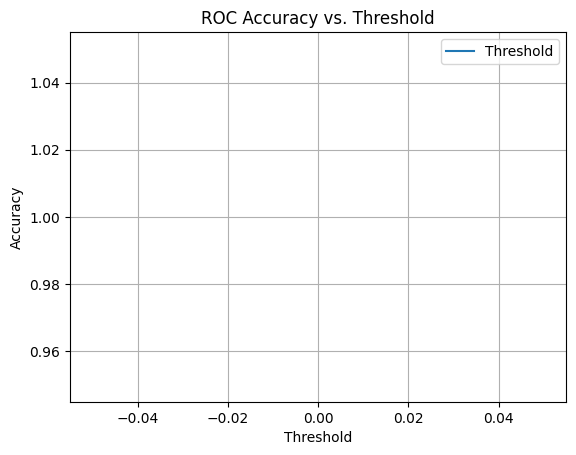

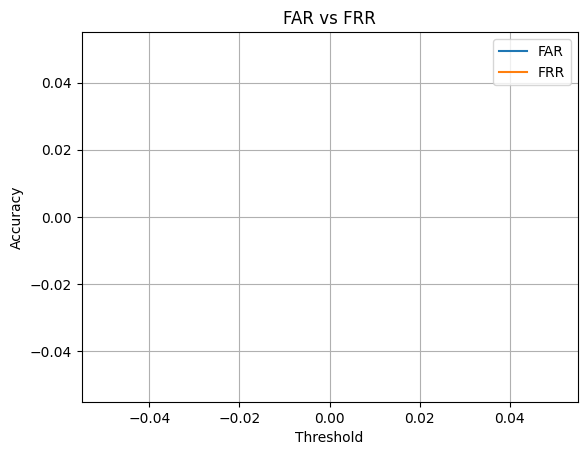

(1.0, 0.0, 0.0, 0.0)

In [ ]:
max_acc, threshold,far,frr = far_frr(np.array(pred), np.array(tr_y))
max_acc, threshold,far[-1],frr[-1]

### Common metrics used to evaluate the performance of biometric systems, such as signature verification.
* **False Acceptance Rate (FAR)**: The rate at which unauthorized persons are incorrectly accepted by the system. This is calculated as the number of false acceptances divided by the total number of false acceptance opportunities (i.e., the total number of negative samples). Commonly known as ***False Positive Rate (FPR)***
    * FAR is calculated as FP / (FP + TN).


* **False Rejection Rate (FRR)**: The rate at which authorized persons are incorrectly rejected by the system. This is calculated as the number of false rejections divided by the total number of false rejection opportunities (i.e., the total number of positive samples). Commonly known as ***False Negative Rate (FNR)***
    * FRR is calculated as FN / (FN + TP).

In [ ]:
from sklearn.metrics import classification_report

pred_binary = np.array(pred) <= threshold

print(classification_report(tr_y, pred_binary))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1497
         1.0       1.00      1.00      1.00      1447

    accuracy                           1.00      2944
   macro avg       1.00      1.00      1.00      2944
weighted avg       1.00      1.00      1.00      2944



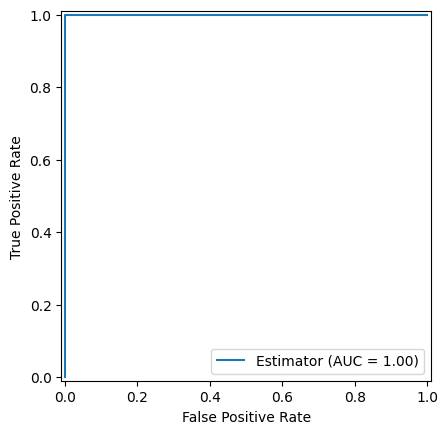

In [ ]:
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(tr_y, pred_binary)
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                  estimator_name='Estimator')
display.plot()
plt.show()

EER: 0.0000
Threshold at EER: 1.0000


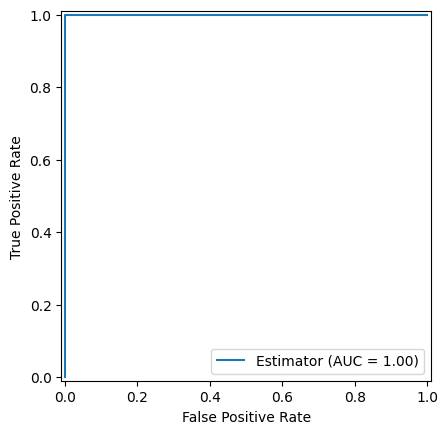

In [ ]:
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt

fpr, tpr, thresholds = metrics.roc_curve(tr_y, pred_binary)

fnr = 1 - tpr  # FNR = 1 - TPR

abs_diff = np.abs(fpr - fnr)

eer_index = np.argmin(abs_diff)
eer = fpr[eer_index]  # EER là FPR tại ngưỡng đó
threshold_at_eer = thresholds[eer_index]

print(f"EER: {eer:.4f}")
print(f"Threshold at EER: {threshold_at_eer:.4f}")

roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='Estimator')
display.plot()
plt.show()


##Inference

In [ ]:
def predict_score():
    '''Predict distance score and classify test images as Genuine or Forged'''
    test_point, test_label = next(test_gen)
    img1, img2 = test_point[0], test_point[1]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 10))
    ax1.imshow(np.squeeze(img1[0]), cmap='gray')
    ax2.imshow(np.squeeze(img2[0]), cmap='gray')
    ax1.set_title('Genuine')
    if test_label[0] == 1:
        ax2.set_title('Genuine')
    else:
        ax2.set_title('Forged')
    ax1.axis('off')
    ax2.axis('off')
    plt.show()
    result = model.predict([img1, img2])
    diff = result[0][0]
    print("Difference Score = ", diff)
    if diff > threshold:
        print("Its a FORGED Signature")
    else:
        print("Its a GENUINE Signature")

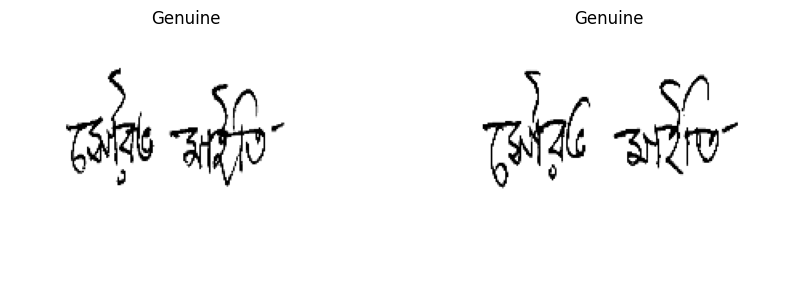

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Difference Score =  1.9943099
Its a FORGED Signature


In [ ]:
predict_score()

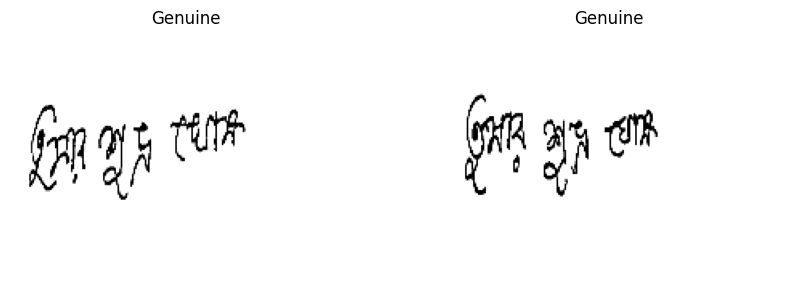

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Difference Score =  0.0
Its a GENUINE Signature


In [ ]:
predict_score()

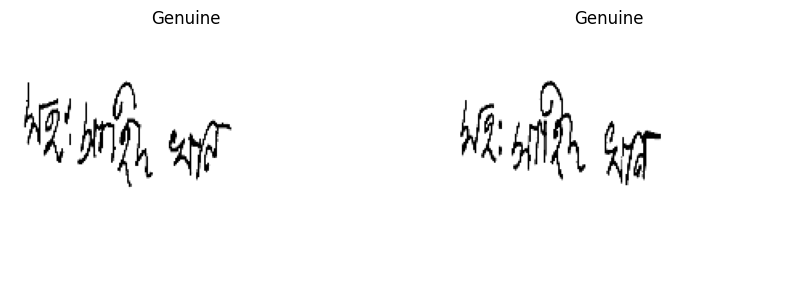

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Difference Score =  0.0
Its a GENUINE Signature


In [ ]:
predict_score()

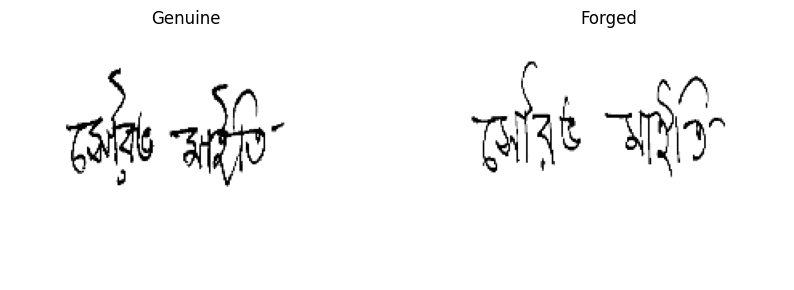

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Difference Score =  0.89627254
Its a FORGED Signature


In [ ]:
predict_score()

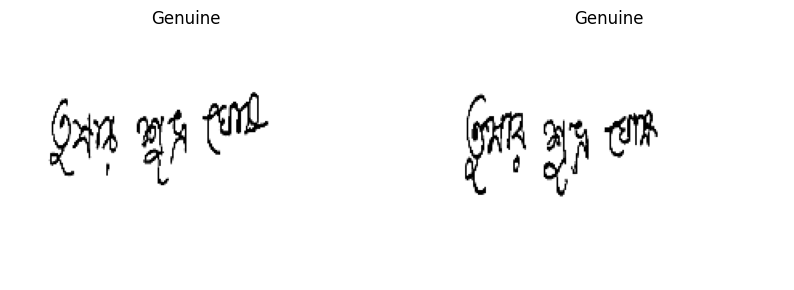

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Difference Score =  0.0
Its a GENUINE Signature


In [ ]:
predict_score()

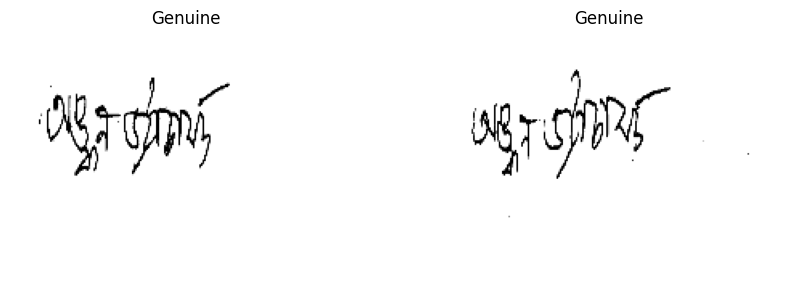

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Difference Score =  0.0
Its a GENUINE Signature


In [ ]:
predict_score()

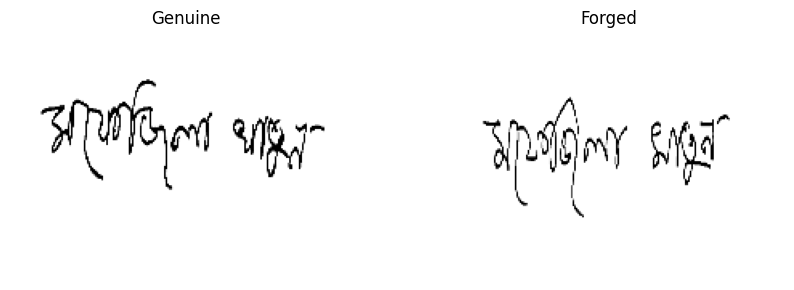

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
Difference Score =  2.478246
Its a FORGED Signature


In [ ]:
predict_score()

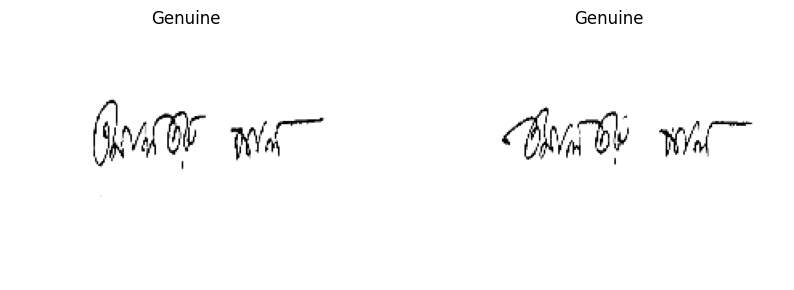

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Difference Score =  0.0
Its a GENUINE Signature


In [ ]:
predict_score()

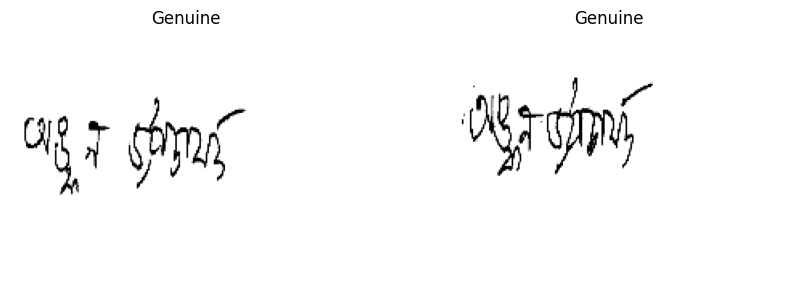

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Difference Score =  0.0
Its a GENUINE Signature


In [ ]:
predict_score()